In [1]:
import json
import trt_pose.coco
import trt_pose.models
import torch
import torch2trt
from torch2trt import TRTModule
import time
import cv2
import torchvision.transforms as transforms
import PIL.Image, PIL.ImageDraw
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects
import argparse
import os.path
import numpy as np
from sklearn import svm
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import metrics

In [2]:
def draw_keypoints(img, key, i):
    thickness = 5
    w, h = img.size
    draw = PIL.ImageDraw.Draw(img)
    # Annotate skeleton
    if all(key[0][1:]):
        #print(key[0])
        draw.text((key[0][2]*w, (key[0][1]-0.05)*h), text = f"Figure {i}", fill='red')
    #draw Rankle -> RKnee (16-> 14)
    if all(key[16]) and all(key[14]):
        draw.line([ int(key[16][2] * w), int(key[16][1] * h), int(key[14][2] * w), int(key[14][1] * h)],width = thickness, fill=(51,51,204))
    #draw RKnee -> Rhip (14-> 12)
    if all(key[14]) and all(key[12]):
        draw.line([ int(key[14][2] * w), int(key[14][1] * h), int(key[12][2] * w), int(key[12][1] * h)],width = thickness, fill=(51,51,204))
    #draw Rhip -> Lhip (12-> 11)
    if all(key[12]) and all(key[11]):
        draw.line([ int(key[12][2] * w), int(key[12][1] * h), int(key[11][2] * w), int(key[11][1] * h)],width = thickness, fill=(51,51,204))
    #draw Lhip -> Lknee (11-> 13)
    if all(key[11]) and all(key[13]):
        draw.line([ int(key[11][2] * w), int(key[11][1] * h), int(key[13][2] * w), int(key[13][1] * h)],width = thickness, fill=(51,51,204))
    #draw Lknee -> Lankle (13-> 15)
    if all(key[13]) and all(key[15]):
        draw.line([ int(key[13][2] * w), int(key[13][1] * h), int(key[15][2] * w), int(key[15][1] * h)],width = thickness, fill=(51,51,204))

    #draw Rwrist -> Relbow (10-> 8)
    if all(key[10]) and all(key[8]):
        draw.line([ int(key[10][2] * w), int(key[10][1] * h), int(key[8][2] * w), int(key[8][1] * h)],width = thickness, fill=(255,255,51))
    #draw Relbow -> Rshoulder (8-> 6)
    if all(key[8]) and all(key[6]):
        draw.line([ int(key[8][2] * w), int(key[8][1] * h), int(key[6][2] * w), int(key[6][1] * h)],width = thickness, fill=(255,255,51))
    #draw Rshoulder -> Lshoulder (6-> 5)
    if all(key[6]) and all(key[5]):
        draw.line([ int(key[6][2] * w), int(key[6][1] * h), int(key[5][2] * w), int(key[5][1] * h)],width = thickness, fill=(255,255,0))
    #draw Lshoulder -> Lelbow (5-> 7)
    if all(key[5]) and all(key[7]):
        draw.line([ int(key[5][2] * w), int(key[5][1] * h), int(key[7][2] * w), int(key[7][1] * h)],width = thickness, fill=(51,255,51))
    #draw Lelbow -> Lwrist (7-> 9)
    if all(key[7]) and all(key[9]):
        draw.line([ int(key[7][2] * w), int(key[7][1] * h), int(key[9][2] * w), int(key[9][1] * h)],width = thickness, fill=(51,255,51))

    #draw Rshoulder -> RHip (6-> 12)
    if all(key[6]) and all(key[12]):
        draw.line([ int(key[6][2] * w), int(key[6][1] * h), int(key[12][2] * w), int(key[12][1] * h)],width = thickness, fill=(153,0,51))
    #draw Lshoulder -> LHip (5-> 11)
    if all(key[5]) and all(key[11]):
        draw.line([ int(key[5][2] * w), int(key[5][1] * h), int(key[11][2] * w), int(key[11][1] * h)],width = thickness, fill=(153,0,51))


    #draw nose -> Reye (0-> 2)
    if all(key[0][1:]) and all(key[2]):
        draw.line([ int(key[0][2] * w), int(key[0][1] * h), int(key[2][2] * w), int(key[2][1] * h)],width = thickness, fill=(219,0,219))

    #draw Reye -> Rear (2-> 4)
    if all(key[2]) and all(key[4]):
        draw.line([ int(key[2][2] * w), int(key[2][1] * h), int(key[4][2] * w), int(key[4][1] * h)],width = thickness, fill=(219,0,219))

    #draw nose -> Leye (0-> 1)
    if all(key[0][1:]) and all(key[1]):
        draw.line([ int(key[0][2] * w), int(key[0][1] * h), int(key[1][2] * w), int(key[1][1] * h)],width = thickness, fill=(219,0,219))

    #draw Leye -> Lear (1-> 3)
    if all(key[1]) and all(key[3]):
        draw.line([ int(key[1][2] * w), int(key[1][1] * h), int(key[3][2] * w), int(key[3][1] * h)],width = thickness, fill=(219,0,219))

    #draw nose -> neck (0-> 17)
    if all(key[0][1:]) and all(key[17]):
        draw.line([ int(key[0][2] * w), int(key[0][1] * h), int(key[17][2] * w), int(key[17][1] * h)],width = thickness, fill=(255,255,0))
 
    
    
    return img


In [3]:
'''
hnum: 0 based human index
kpoint : index + keypoints (float type range : 0.0 ~ 1.0 ==> later multiply by image width, height)
'''
def get_keypoint(humans, hnum, peaks):
    #check invalid human index
    kpoint = []
    human = humans[0][hnum]
    C = human.shape[0]
    for j in range(C):
        k = int(human[j])
        if k >= 0:
            peak = peaks[0][j][k]   # peak[1]:width, peak[0]:height
            peak = (j, float(peak[0]), float(peak[1]))
            kpoint.append(peak)
            #print('index:%d : success [%5.3f, %5.3f]'%(j, peak[1], peak[2]) )
        else:    
            peak = (j, None, None)
            kpoint.append(peak)
            #print('index:%d : None'%(j) )
    return kpoint

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

'''
Draw to inference (small)image
'''
def execute(img):
    start = time.time()
    data = preprocess(img)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    end = time.time()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    for i in range(counts[0]):
        #print("Human index:%d "%( i ))
        get_keypoint(objects, i, peaks)
    print("Human count:%d len:%d "%(counts[0], len(counts)))
    print('===== Net FPS :%f ====='%( 1 / (end - start)))
    draw_objects(img, counts, objects, peaks)
    return img

'''
Draw to original image
'''
def execute_2(img, org):
    start = time.time()
    data = preprocess(img)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    end = time.time()
    parse_objects = ParseObjects(topology)
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)

    npeaks = peaks.numpy()[0]
    for i in range(counts[0]):
        #print("Human index:%d "%( i ))
        kpoint = get_keypoint(objects, i, peaks)
        #print(kpoint)
        org = draw_keypoints(org, kpoint, i)
    #print("Human count:%d len:%d "%(counts[0], len(counts)))
    print('===== Net FPS :%f ====='%( 1 / (end - start)))
    return org, npeaks, counts[0]

# This more Numpy heavy method takes 60% of the time and less memory
def scalepose(pose):
    means = np.array([np.mean(pose[:,0]),np.mean(pose[:,1])])
    stds = np.array([np.std(pose[:,0]),np.std(pose[:,1])])
    if np.count_nonzero(stds) != 2: return pose # Bail out on an empty Skeleton
    pose = (pose.T - means[:,None]) / stds[:,None]
    return pose.T

def execute_classify(img, org, threshold = 8):
    data = preprocess(img)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    end = time.time()
    parse_objects = ParseObjects(topology)
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    npeaks = peaks.numpy()[0]
    skeletons = list()
    if counts[0] == 0: y_pred = [-1]
    for i in range(counts[0]):
        skeleton = scalepose(npeaks[:,i]).flatten()
        if np.count_nonzero(skeleton) >= threshold:
            skeletons.append(skeleton)
        if len(skeletons)>0: 
            y_pred = poseclass.predict(skeletons)
        else: 
            print("No Skeletons")
            y_pred = [-1]
    print(y_pred)
    return y_pred, counts[0]

def execute_classify2(img, org, threshold = 8):
    box = ['green','red','white']
    data = preprocess(img)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    end = time.time()
    parse_objects = ParseObjects(topology)
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    npeaks = peaks.numpy()[0]
    skeletons = list()
    skpresence = list()
    if counts[0] == 0: y_pred = [-1]
    for i in range(counts[0]):
        #skeleton = scalepose(npeaks[:,i]).flatten()
        #if np.count_nonzero(skeleton) >= threshold:
        if np.count_nonzero(npeaks[:,i]) >= threshold:
            print(np.count_nonzero(npeaks[:,i]))
            skeleton = scalepose(npeaks[:,i]).flatten()
            skeletons.append(skeleton)
            skpresence.append(True)
        else: skpresence.append(False)
        if len(skeletons)>0: 
            y_pred = poseclass.predict(skeletons)
        else: 
            print("No Skeletons")
            y_pred = [-1]
    for i in range(counts[0]):
        #print("Human index:%d "%( i ))
        kpoint = get_keypoint(objects, i, peaks)
        #print(kpoint)
        org = draw_keypoints(org, kpoint, i)
    thickness = 5
    w, h = org.size
    draw = PIL.ImageDraw.Draw(org)
    for i in range(counts[0]):
        if skpresence[i]:
            skeleton = npeaks[:,i] 
            xMax = np.amax(skeleton[:,1])+0.05
            yMax = np.amax(skeleton[:,0])+0.05
            xMin = np.amin(skeleton[np.nonzero(skeleton[:,1])][:,1])-0.05
            yMin = np.amin(skeleton[np.nonzero(skeleton[:,0])][:,0])-0.05
            draw.rectangle((xMin*w,yMin*h,xMax*w,yMax*h),
                           fill=None,width=3,
                           outline=box[y_pred[i]])
    return y_pred, counts[0], org, npeaks

def infer(src_image, cat = 0, single = False):
    src = cv2.imread(src_image, cv2.IMREAD_COLOR)
    pilimg = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    pilimg = PIL.Image.fromarray(pilimg)
    orgimg = pilimg.copy()

    image = cv2.resize(src, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
    parse_objects = ParseObjects(topology)
    draw_objects = DrawObjects(topology)
    for x in range(1):
        img = image.copy()
        #img = execute(img)
        pilimg, npeaks, humans = execute_2(img, orgimg)
        #cv2.imshow('key',img)

    dir, filename = os.path.split(src_image)
    dir, folder = os.path.split(dir)
    name, ext = os.path.splitext(filename)
    pilimg.save(os.path.join(dir,f'X_{folder}/resnet_{name}.png'))
    #pilimg.save('/home/mscai/nonenv/training_images/X_correct/%s_%s.png'%('resnet', name))
    skeletons = list()
    if single:
        skeleton = npeaks[:,0]
        skeletons.append(npeaks[:,0].copy())
    else:    
        for i  in range(humans): 
            skeleton = npeaks[:,i]
            if skeleton.sum() != 0.0: #Get rid of ghosts (skeletons generated with 0 keypoints)
                print(f"Human {i}")
                skeletons.append(npeaks[:,i].copy())
    skeletons = np.array(skeletons)
    
    # Generate keypoint dictionaries and save to JSON
    hdict = dict()
    for i in range(len(skeletons)):
        kdict = dict()
        for (row,keypoint) in zip(skeletons[i],keypoints):
            kdict.update({keypoint:list(row.astype(float))})
        hdict.update({f"human_{i}":{"category":cat, "skeleton":kdict}})
                    
    jsonfile = os.path.join(dir,f'X_{folder}/resnet_{name}.json')
    print(jsonfile)
    with open(jsonfile, "w") as outfile: 
        json.dump(hdict, outfile, indent=4)

    return skeletons
  
def predict(src_image, threshold = 8):
    src = cv2.imread(src_image, cv2.IMREAD_COLOR)
    pilimg = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    pilimg = PIL.Image.fromarray(pilimg)
    orgimg = pilimg.copy()
    image = cv2.resize(src, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
    parse_objects = ParseObjects(topology)
    draw_objects = DrawObjects(topology)
    img = image.copy()
    y_pred, humans, pilimg, npeaks = execute_classify2(img, orgimg, threshold)
    pilimg.save(os.path.join('/home/mscai/gdp/test_images/test.png'))
    return y_pred, humans, npeaks                                                                       
    #cv2.imshow('key',img)
    #dir, filename = os.path.split(src_image)
    #dir, folder = os.path.split(dir)
    #name, ext = os.path.splitext(filename)
    #pilimg.save(os.path.join(dir,f'pred_{folder}/classed_{name}.png'))

In [4]:
'''
parser = argparse.ArgumentParser(description='TensorRT pose estimation run')
parser.add_argument('--image', type=str, default='/home/mscai/nonenv/test_images/humans_7.jpg')
parser.add_argument('--model', type=str, default='resnet', help = 'resnet or densenet' )
args = parser.parse_args()
'''

with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)
num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

In [5]:
print('------ model = densenet--------')
start = time.time()
MODEL_WEIGHTS = 'densenet121_baseline_att_256x256_B_epoch_160.pth'
OPTIMIZED_MODEL = 'densenet121_baseline_att_256x256_B_epoch_160_trt.pth'
model = trt_pose.models.densenet121_baseline_att(num_parts, 2 * num_links).cuda().eval()
WIDTH = 256
HEIGHT = 256
print(f"Time taken: {time.time()-start}")

------ model = densenet--------
Time taken: 656.6040680408478


In [5]:
print('------ model = resnet--------')
MODEL_WEIGHTS = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
WIDTH = 224
HEIGHT = 224

------ model = resnet--------


In [6]:
'''
if 'resnet' in args.model:
    print('------ model = resnet--------')
    MODEL_WEIGHTS = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
    OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
    model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
    WIDTH = 224
    HEIGHT = 224

else:    
    print('------ model = densenet--------')
    MODEL_WEIGHTS = 'densenet121_baseline_att_256x256_B_epoch_160.pth'
    OPTIMIZED_MODEL = 'densenet121_baseline_att_256x256_B_epoch_160_trt.pth'
    model = trt_pose.models.densenet121_baseline_att(num_parts, 2 * num_links).cuda().eval()
    WIDTH = 256
    HEIGHT = 256
'''


data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()
if os.path.exists(OPTIMIZED_MODEL) == False:
    print("Optimising...")
    model.load_state_dict(torch.load(MODEL_WEIGHTS))
    model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
    torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)
    
print("Loading...")
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))
mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

keypoints = [
    "nose", 
    "left_eye",
    "right_eye",
    "left_ear",
    "right_ear",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
    "neck"
    ]

Loading...


In [7]:
file = open("poseclass.pkl",'rb')
poseclass = pickle.load(file)
file.close()

In [6]:
src_image = '/home/mscai/gdp/training_images/test/0011.jpeg'
skeletons = infer(src_image, 0)

===== Net FPS :0.016804 =====
Human 0
Human 1


In [8]:
rawPath = '/home/mscai/gdp/test_images/nonlift/'
rawImgs = [x for x in os.listdir(rawPath) if (x[-3:] in ['jpg','peg','png']) and (x[0] != '.')]
infstart = time.time()
for rawImg in rawImgs:
    infer(rawPath + rawImg, 2, single=False)
print(f"Total FPS = {(len(rawImgs)+1)/(time.time() - infstart)}")

===== Net FPS :0.022579 =====
Human 0
Human 1
/home/mscai/gdp/test_images/X_nonlift/resnet_render28_3_28.json
===== Net FPS :0.070833 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render29_1_6.json
===== Net FPS :0.873618 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render28_2_18.json
===== Net FPS :10.743579 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render29_0_4.json
===== Net FPS :13.622337 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render21_0_6.json
===== Net FPS :4.756612 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render29_0_5.json
===== Net FPS :12.046644 =====
Human 0
Human 1
/home/mscai/gdp/test_images/X_nonlift/resnet_render28_3_26.json
===== Net FPS :14.590304 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render29_2_24.json
===== Net FPS :15.141946 =====
Human 0
/home/mscai/gdp/test_images/X_nonlift/resnet_render28_2_9.json
===== Net FPS :14.906297 =====
Human 0
/home/mscai/gdp/test_images

In [9]:
rawPath = '/home/mscai/gdp/test_images/correct/'
rawImgs = [x for x in os.listdir(rawPath) if (x[-3:] in ['jpg','peg','png']) and (x[0] != '.')]
infstart = time.time()
for rawImg in rawImgs:
    infer(rawPath + rawImg, 0, single=False)
print(f"Total FPS = {(len(rawImgs)+1)/(time.time() - infstart)}")

===== Net FPS :6.048372 =====
Human 0
/home/mscai/gdp/test_images/X_correct/resnet_render17_0_3.json
===== Net FPS :10.666857 =====
Human 0
/home/mscai/gdp/test_images/X_correct/resnet_render16_1_20.json
===== Net FPS :14.278093 =====
Human 0
/home/mscai/gdp/test_images/X_correct/resnet_render30_0_27.json
===== Net FPS :14.518940 =====
Human 0
Human 1
/home/mscai/gdp/test_images/X_correct/resnet_render34_3_16.json
===== Net FPS :14.065547 =====
Human 0
/home/mscai/gdp/test_images/X_correct/resnet_render30_3_13.json
===== Net FPS :14.333816 =====
Human 0
/home/mscai/gdp/test_images/X_correct/resnet_render30_0_25.json
===== Net FPS :14.690774 =====
Human 0
/home/mscai/gdp/test_images/X_correct/resnet_render17_1_12.json
===== Net FPS :14.553398 =====
Human 0
Human 1
/home/mscai/gdp/test_images/X_correct/resnet_render30_2_24.json
===== Net FPS :15.255343 =====
Human 0
Human 1
/home/mscai/gdp/test_images/X_correct/resnet_render18_3_19.json
===== Net FPS :14.590812 =====
Human 0
/home/mscai/

In [10]:
rawPath = '/home/mscai/gdp/test_images/incorrect/'
rawImgs = [x for x in os.listdir(rawPath) if (x[-3:] in ['jpg','peg','png']) and (x[0] != '.')]
infstart = time.time()
for rawImg in rawImgs:
    infer(rawPath + rawImg, 1, single=False)
print(f"Total FPS = {(len(rawImgs)+1)/(time.time() - infstart)}")

===== Net FPS :5.017944 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render31_0_13.json
===== Net FPS :10.364572 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render32_2_20.json
===== Net FPS :11.648903 =====
/home/mscai/gdp/test_images/X_incorrect/resnet_render19_3_23.json
===== Net FPS :12.718800 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render19_1_2.json
===== Net FPS :12.980277 =====
/home/mscai/gdp/test_images/X_incorrect/resnet_render19_0_6.json
===== Net FPS :14.531868 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render31_3_16.json
===== Net FPS :14.630715 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render19_2_30.json
===== Net FPS :14.566995 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render19_1_8.json
===== Net FPS :14.697826 =====
Human 0
/home/mscai/gdp/test_images/X_incorrect/resnet_render20_1_30.json
===== Net FPS :14.780698 =====
/home/mscai/gdp/test_images/X_incorrect/resn

In [12]:
rawPath = '/home/mscai/gdp/training_images/incorrect/'
rawImgs = [x for x in os.listdir(rawPath) if (x[-3:] in ['jpg','peg','png']) and (x[0] != '.')]
infstart = time.time()
for rawImg in rawImgs:
    infer(rawPath + rawImg, 1, single=False)
print(f"Total FPS = {(len(rawImgs)+1)/(time.time() - infstart)}")

===== Net FPS :5.772889 =====
Human 0
/home/mscai/gdp/training_images/X_incorrect/resnet_render49_0_14.json
===== Net FPS :9.073336 =====
Human 0
Human 1
/home/mscai/gdp/training_images/X_incorrect/resnet_render49_1_3.json
===== Net FPS :12.124929 =====
Human 0
/home/mscai/gdp/training_images/X_incorrect/resnet_render0_1_25.json
===== Net FPS :14.233516 =====
Human 0
/home/mscai/gdp/training_images/X_incorrect/resnet_render11_1_0.json
===== Net FPS :14.631837 =====
/home/mscai/gdp/training_images/X_incorrect/resnet_render49_2_28.json
===== Net FPS :14.258920 =====
/home/mscai/gdp/training_images/X_incorrect/resnet_render40_1_5.json
===== Net FPS :14.986669 =====
/home/mscai/gdp/training_images/X_incorrect/resnet_render49_3_27.json
===== Net FPS :14.792636 =====
Human 0
/home/mscai/gdp/training_images/X_incorrect/resnet_render3_2_12.json
===== Net FPS :14.334698 =====
/home/mscai/gdp/training_images/X_incorrect/resnet_render40_1_7.json
===== Net FPS :14.993419 =====
/home/mscai/gdp/trai

In [15]:
rawPath = '/home/mscai/gdp/training_images/correct/'
rawImgs = [x for x in os.listdir(rawPath) if (x[-3:] in ['jpg','peg','png']) and (x[0] != '.')]
infstart = time.time()
for rawImg in rawImgs:
    infer(rawPath + rawImg, 0, single=False)
print(f"Total FPS = {(len(rawImgs)+1)/(time.time() - infstart)}")

===== Net FPS :4.613490 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render12_0_16.json
===== Net FPS :11.703445 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render48_0_23.json
===== Net FPS :13.996503 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render4_0_19.json
===== Net FPS :14.860876 =====
Human 0
Human 1
/home/mscai/gdp/training_images/X_correct/resnet_render46_2_11.json
===== Net FPS :15.039655 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render50_0_19.json
===== Net FPS :14.694685 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render44_2_17.json
===== Net FPS :14.987633 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render5_2_26.json
===== Net FPS :14.726157 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render8_3_31.json
===== Net FPS :15.290157 =====
Human 0
/home/mscai/gdp/training_images/X_correct/resnet_render5_1_11.json
===== Net FPS :14.668219 =====
Hum

In [16]:
rawPath = '/home/mscai/gdp/training_images/nonlift/'
rawImgs = [x for x in os.listdir(rawPath) if (x[-3:] in ['jpg','peg','png']) and (x[0] != '.')]
infstart = time.time()
for rawImg in rawImgs:
    infer(rawPath + rawImg, 2, single=False)
print(f"Total FPS = {(len(rawImgs)+1)/(time.time() - infstart)}")

===== Net FPS :14.395360 =====
Human 0
Human 1
/home/mscai/gdp/training_images/X_nonlift/resnet_render26_0_25.json
===== Net FPS :15.110090 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render26_3_18.json
===== Net FPS :14.630255 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render51_3_0.json
===== Net FPS :14.722125 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render42_3_9.json
===== Net FPS :14.951783 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render41_1_4.json
===== Net FPS :15.153763 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render15_3_29.json
===== Net FPS :14.890421 =====
Human 0
Human 1
/home/mscai/gdp/training_images/X_nonlift/resnet_render26_1_21.json
===== Net FPS :14.720317 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render14_1_28.json
===== Net FPS :14.655816 =====
Human 0
/home/mscai/gdp/training_images/X_nonlift/resnet_render15_3_27.json
===== Net FPS :14.600462

In [53]:
testpath = '/home/mscai/gdp/test_images/incorrect/'
testImgs = [x for x in os.listdir(testpath) if x[-3:] == 'png']
testImg = os.path.join(testpath, testImgs[4])
y_pred = list()
for img in testImgs:
    y_pred.append(list(predict(os.path.join(testpath, img),threshold=6)[0]))

incorrect_pred = [y[0] for y in y_pred]
incorrect_true = [1 for _ in range(len(testImgs))]

22
6
8
28
22
8
20
28
10
20
34
24
14
8
No Skeletons
32
10
28
28
28
No Skeletons
20
12
24
28
22
No Skeletons
30
16
12
28
12
12
No Skeletons
No Skeletons
14
No Skeletons
12
12
28
24
26
28
28
26
12
16
12
14
30
6
No Skeletons
28
No Skeletons
No Skeletons
24
24
24
16
12
28
6
26
No Skeletons
32
24
10
22
24
30
28
28
No Skeletons
No Skeletons
24
6
20
8
12
6
20
16
32
20
24
28
24
12
28
No Skeletons
6
10
18
26
12
24
22
No Skeletons
No Skeletons
28
16
12
8
8
10
22
No Skeletons
20
12
30
10
8
28
10
No Skeletons
No Skeletons
12
16
26
8
18
No Skeletons
22
30
No Skeletons
8
No Skeletons
18
8
28
10
22
26
32
8
No Skeletons
16
12
14
16
30
6
32
No Skeletons
10
18
12
28
30
28
30
8
8
26
No Skeletons
No Skeletons
No Skeletons
14
12
26


In [54]:
testpath = '/home/mscai/gdp/test_images/correct/'
testImgs = [x for x in os.listdir(testpath) if x[-3:] == 'png']
testImg = os.path.join(testpath, testImgs[4])
y_pred = list()
for img in testImgs:
    y_pred.append(list(predict(os.path.join(testpath, img),threshold=6)[0]))
    
correct_pred = [y[0] for y in y_pred]   
correct_true = [0 for _ in range(len(testImgs))]

30
32
26
32
30
30
32
30
22
30
32
30
32
34
30
32
34
30
6
32
No Skeletons
34
26
8
16
32
34
26
26
34
26
28
No Skeletons
32
24
34
32
32
36
36
34
24
No Skeletons
32
6
30
30
32
24
24
34
34
26
32
32
20
32
34
24
30
No Skeletons
No Skeletons
No Skeletons
22
36
26
24
28
34
10
34
32
8
32
30
28
16
32
34
34
14
30
36
34
30
No Skeletons
26
34
36
18
28
28
24
34
30
No Skeletons
36
32
32
30
22
30
30
26
26
22
26
28
28
24
36
36
24
30
22
30
34
26
No Skeletons
32
32
26
32
26
30
28
28
6
26
36
32
36
34
30
36
22
10
26
36
18
34
30
26
32
32
34
30
8
30
26
32
32
26
32
26
34
18
24
36
34
34
22
32
32
20
34
30
26
22
26
32
32
8
36
32
32
26
30
34
26
36
36
8
32
28
28
36
24
8
30
32
24
30
26
32
28
32
26
32
32
18
28
26
24
32
24
28
26
14
36
32
24
24
26
30
32
28
No Skeletons
No Skeletons
24
30
28
32
28
28
30
12
32
24
28
30
28
32
28
34
26
36
28
34
34
12
28
32
30
34
26
28
14
24
26
30
30
6
32
34
32
26
30
28
28
30
22
34
30
36
28
32
20
No Skeletons
28
28
26
34
28
30
30
26
26
32
36
26
12
32
No Skeletons
10
12
32
30
16
32
34
30
28
2

In [55]:
testpath = '/home/mscai/gdp/test_images/nonlift/'
testImgs = [x for x in os.listdir(testpath) if x[-3:] == 'png']
testImg = os.path.join(testpath, testImgs[4])
y_pred = list()
for img in testImgs:
    y_pred.append(list(predict(os.path.join(testpath, img),threshold=6)[0]))

nonlift_pred = [y[0] for y in y_pred]
nonlift_true = [2 for _ in range(len(testImgs))]

26
28
32
30
30
36
32
32
30
32
30
36
30
32
32
34
30
32
32
36
30
36
30
34
32
36
32
28
36
30
32
34
34
32
6
32
30
30
32
36
30
30
32
36
30
36
26
28
30
32
30
30
28
32
32
34
30
36
32
26
32
34
36
36
32
32
32
32
30
30
36
32
30
32
30
26
32
32
32
30
30
30
32
30
32
26
30
30
32
32
32
32
32
36
26
32
36
22
6
36
30
36
32
34
32
30
30
34
32
32
30
32
32
32
34
32
26
26
32
32
30
30
36
32
32
32
28
32
36
36


In [56]:
allpreds = correct_pred + incorrect_pred + nonlift_pred
alltrues = correct_true + incorrect_true + nonlift_true

In [26]:
def confMatrix(truth: list, predictions: list, log = False):
    '''
    predictions, truth as lists of values.
    Class names and quantity calculated automatically from unique values across both lists.
    Set log to True for a logarithmic colour map - good for high performing classifiers.
    '''
   
    classnames = sorted(list(set(list(truth) + list(predictions)))) #Produces sorted list of unique classnames
    if log: norm = matplotlib.colors.LogNorm()
    else:   norm = matplotlib.colors.Normalize()
    matrix = pd.DataFrame(metrics.confusion_matrix(truth, predictions),
                      index = classnames,
                      columns = classnames)
    
    fig = plt.figure(figsize = (10,8))
    heatmap = sns.heatmap(matrix, annot = True, fmt = "d",
                          cmap = "rocket_r", square = True,
                          vmin = 0.001,# Zero value catcher for LogNorm
                          norm = norm)
 
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation = 0, ha = 'right', fontsize = 14)
   
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation = 0, ha = 'right', fontsize = 14)
  
    # Corrects ylim issues under matplotlib 3.1.1. Comment this out if not required.
    if matplotlib.__version__ == '3.1.1':
        plt.ylim(len(classnames),0)
        print("Note: Matplotlib version 3.1.1 has some compatability issues with Seaborn.")
   
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [57]:
classes = ["Safe","Unsafe","Nonlifting",".Empty"]
allpred = [classes[x] for x in allpreds]
alltrue = [classes[x] for x in alltrues]


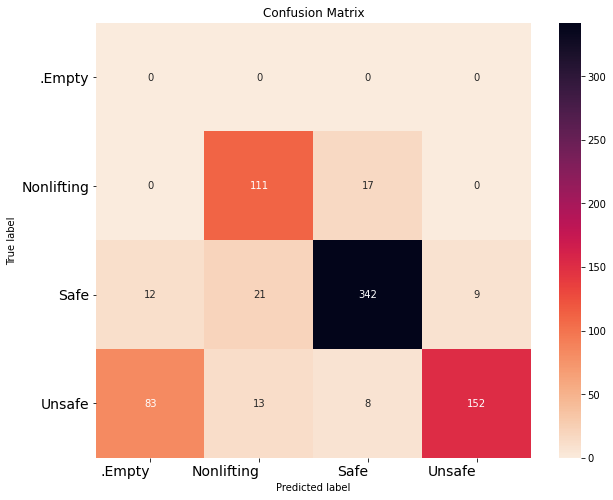

In [41]:
confMatrix(alltrue,allpred,
           #log=True
          )

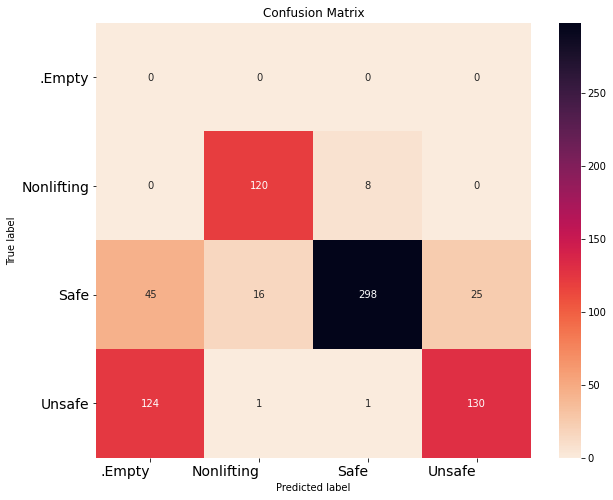

In [58]:
# Dense confmatrix

confMatrix(alltrue,allpred,
           #log=True
          )